# COSC 89.21 | Professor Vosoughi | Winter 2021

# Final Project: Predicting StackOverflow R Question Binary Rating (Positive or Negative Score) from Question Text Data

# By Clayton Bass (Undergraduate '22)

## The emphasis of this project is on exploring and tackling the cleaning/pre-processing process for a very messy, unstructured dataset that includes lots of code, HTML tags, formal mathematical/programming language, and not much sentiment. However, modeling is still included so as to answer the question at hand.

## Section 0: Loading the Data
### Data Source (Kaggle): https://www.kaggle.com/stackoverflow/rquestions?select=Questions.csv (Files Downloaded: 'Answers.csv', 'Questions.csv', 'Tags.csv'; File Used: 'Questions.csv')

In [1]:
# Import a few relevant packages to begin
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import nltk
import re

In [2]:
# Import the data 
questions_raw = pd.read_csv('Questions.csv')

In [3]:
# Change the dates column to pandas datetime object
questions_raw['CreationDate'] = pd.to_datetime(questions_raw['CreationDate'])
questions_raw.index = questions_raw['CreationDate'] 

In [4]:
# Look only at the questions from 2016 and 2017, so that
# we examine only the more recent R versions (since the code
# is harder to interpret from older versions);
# however, get rid of all questions that have "0" as their score,
# since there is no insight (we will assume) into their quality,
# acknowledging that some questions may be controversial
# and get many upvotes and many downvotes thathappen to equalize
# at 0. 
questions_body_2016 = questions_raw['Body']['2016']
questions_body_2017 = questions_raw['Body']['2017']
questions_body = pd.concat([questions_body_2016, questions_body_2017],
                          axis=0)

questions_title_2016 = questions_raw['Title']['2016']
questions_title_2017 = questions_raw['Title']['2017']
questions_title = pd.concat([questions_title_2016, questions_title_2017],
                          axis=0)

score_2016 = questions_raw['Score']['2016']
score_2017 = questions_raw['Score']['2017']
score = pd.concat([score_2016, score_2017],
                          axis=0)

In [5]:
# Put together all of the questions' titles and bodies from the
# proper year
questions_full = pd.concat([score, questions_title, questions_body],
                          axis = 1)
questions_full['CreationDate'] = questions_full.index

In [6]:
# Remove all rows where there is a score of 0, for the reasons mentioned
# a couple of cells above (there is no sentimental value to such questions)
questions_full = questions_full[questions_full['Score'] != 0]

In [7]:
# Notice that we have 40736 samples, which should be enough for our purposes
questions_full.shape

(40736, 4)

In [8]:
# Turn 'Score' into binary: 1 if strictly positive, 0 if strictly negative
# (since all scores of 0 have been filtered out)
questions_full['score_binary'] = questions_full['Score'].apply(lambda x: 1 if x > 0 else 0)

In [9]:
# Notice that the data are quite unbalanced, in a ratio of about 1:7
# for class 0:class 1. We therefore will downsample the positive class by half.
questions_full.groupby(['score_binary']).count()

,Score,Title,Body,CreationDate
score_binary,,,,
0,5175,5175,5175,5175
1,35561,35561,35561,35561


In [10]:
# Let's look at a few of the questions to see the kind
# of cleaning we'll need to do. We will need to extract
# the English text data, so we will remove all of the code
# tags (and HTML tags) and the code in between tags so that
# we are left with English text. We will ultimately engage
# in 3 distinct levels/depths of text cleaning.
print(questions_full.iloc[0,2])
print('----------------------------------------')
print(questions_full.iloc[1,2])
print('----------------------------------------')
print(questions_full.iloc[2,2])

<p>What's the best way to get the label of an <strong>actionButton</strong> that is clicked? I have an <strong>actionButton</strong> that has the label updated. When the user clicks, I need to capture that. I tried  input$action2.label and input$action2.text, but neither worked.</p>

<p><strong>ui.R</strong></p>

<pre><code>library(shiny)

shinyUI( fluidPage(

tags$head(tags$style(
  HTML('
       { background-color: #dec4de;}
       #action4 { width: 275 px; color:red; background-color:yellow }
       #action1, #action2, #action3 { color:black; background-color:lime }
       body, label, input, button, select { font-family: "Arial"; }'
  )
)),    

titlePanel("My Shiny App!"),

sidebarLayout(
  sidebarPanel(
    tabsetPanel(type = "tabs", 
                tabPanel("About", "Developer Info here"), 
                tabPanel("How to Use", "User Docs"))

  ),

  mainPanel(
    img(src="capstone1.jpg", align = "center"),
    br(),br(),
    tags$textarea(id="stext", rows=3, cols=80, "Defaul

## Section I: Removing Code Tags/Initial Cleaning; Downsampling; Splitting into Train and Test Sets

#### I.i Remove Code Tags

In [11]:
# Write a function to remove all code tags in our dataset.
# This will serve as the "base" dataset, on top of which we 
# will run all further cleaning and experimentation (since
# the code and tags are not going to be considered really as
# content in our model for the purposes of this project)
def remove_tags(body): 
    # Lowercase the body
    body = body.lower()
    
    # Tokenize the body
    body_tokenized = nltk.word_tokenize(body)

    # Turn back into a string (because some spacing issues between
    # lines, where regular expressions start to fail; this isn't
    # really cleaning the data at all)
    body = ''
    for word in body_tokenized:
        body += word + ' ' 
       
    # Remove everything within HTML tags, including those tags
    # (after scrolling through hundreds of questions to see the
    # most common HTML tags!)
    body = re.sub(r'< code >.+< /code >', ' ', body)
    body = re.sub(r'< pre > < code >[.|\s]{3,}< /code > < /pre >', ' ', body)
    body = re.sub(r'< blockquote >.+< /blockquote >', ' ', body)
    body = re.sub(r'< href=.+>.+< /a >',' ', body)
    body = re.sub(r'< li >.+< /li >', ' ', body)
    body = re.sub(r'< ol >.+< /ol >', ' ', body)
    
    # Get rid of remaining tags that may not have been captured by the above
    body = re.sub('< p >', ' ', body)
    body = re.sub('< /p >', ' ', body)
    body = re.sub('< /pre >', ' ', body)
    body = re.sub('< pre >', ' ', body)
    
    return body

In [12]:
# Apply our function to the data
questions_full['Body'] = questions_full['Body'].apply(lambda x: remove_tags(x))

#### I.ii. Downsampling

In [13]:
# Downsample the data, then split into train and test sets
# (downsample by about half in the positive class)

# Create a dataframe with only the positive class by masking
questions_positive = questions_full[questions_full['score_binary'] == 1]
questions_positive_downsampled = questions_positive.sample(frac = 0.5,
                                                          random_state=0)

# Create a dataframe with only the negative class by masking
questions_negative = questions_full[questions_full['score_binary'] == 0]

# Re-connect the two dataframes back into one
questions_downsampled = pd.concat([questions_positive_downsampled, questions_negative],
                                 axis=0)

#### I.iii. Split into Train and Test Sets

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(questions_downsampled.drop(['score_binary','Score'],axis=1),
                                                   questions_downsampled['score_binary'], random_state=0)

## Section II: Two Variations of Data Cleaning

#### II.a. COMPLETE Data Cleaning

I will now clean the data for the purpose of extracting TFIDF and CountVectorizer features from the data in the next section. I use a differently cleaned dataset for such features because I may want to use some of the messier aspects of the original data (such as symbols or code objects) as features, and I may remove these elements in the cleaning process for TFIDF/CountVectorizer specifically, since TFIDF/CountVectorizer would not work well with punctuation and other LaTeX/HTML commands inside.

There will be one more subsection here where we clean the data slightly less, just to see how that might impact the final results.

In [15]:
IIa_df = X_train.copy()

In [16]:
# Clean the 'Title' column
from nltk.corpus import stopwords

def fully_clean_title(title):
    # Lowercase the title
    title = title.lower()
    
    # Tokenize the title and remove all stopwords
    title_tokenized = nltk.word_tokenize(title)
    my_stopwords = set(stopwords.words('english'))
    title_tokenized = [word for word in title_tokenized if word not in my_stopwords]
    
    # Remove all punctuation
    set_punctuation = {'?','.',',','!','@','#',
                       '%','^','&','*','(',')','-',
                       '{','}','[',']','\\',"|",':',
                       ';','<','>','/','$','~','`','""','\'',
                      '``',"''", "—","'","’","'s"}
    WNL = nltk.WordNetLemmatizer()

    stemmed_words = [WNL.lemmatize(word) for word in title_tokenized
              if word not in set_punctuation]
    
    # Turn back into a string
    mystring = ''
    for word in stemmed_words:
        mystring += word + ' '
        
    return mystring

In [17]:
# Clean the 'Body' column
import re

def fully_clean_body(body):
    # Tokenize the body and remove all stopwords
    body_tokenized = nltk.word_tokenize(body)
    my_stopwords = set(stopwords.words('english'))
    body_tokenized = [word for word in body_tokenized if word not in my_stopwords]

    # Remove all punctuation
    set_punctuation = {'?','.',',','!','@','#',
                       '%','^','&','*','(',')','-',
                       '{','}','[',']','\\',"|",':',
                       ';','<','>','/','$','~','`','""','\'',
                      '``',"''", "—","'","’","'s"}
    
    # Lemmatize the words (since this is more accurate
    # then using the PorterStemmer, generally speaking)
    WNL = nltk.WordNetLemmatizer()

    stemmed_words = [WNL.lemmatize(word) for word in body_tokenized
              if word not in set_punctuation]
    
    # Turn back into a string
    mystring = ''
    for word in stemmed_words:
        mystring += word + ' '
    
    return mystring

In [18]:
# Clean the 'Title' column into a new column
IIa_df['title_cleaned'] = IIa_df['Title'].apply(lambda x: fully_clean_title(x))

In [19]:
# Clean the 'Body' column into a new column
IIa_df['body_cleaned'] = IIa_df['Body'].apply(lambda x: fully_clean_body(x))

In [20]:
# Concatenate the 'Body' and 'Title' text to make modeling easier
IIa_df['text_cleaned'] = IIa_df['title_cleaned'] + ' ' + IIa_df['body_cleaned']

#### Section II.b.: LESS COMPLETE Data Cleaning

Now, we clean the data a little less completely and see (ultimately in section III) how this compares with the fully cleaned dataset.

In [21]:
IIb_df = X_train.copy()

In [22]:
# Clean the 'Title' column only partially, without
# lemmatization
from nltk.corpus import stopwords

def partially_clean_title(title):
    # Lowercase the title
    title = title.lower()
    
    # Tokenize the title and remove all stopwords
    title_tokenized = nltk.word_tokenize(title)
    my_stopwords = set(stopwords.words('english'))
    title_tokenized = [word for word in title_tokenized if word not in my_stopwords]
    
    # Remove all punctuation
    set_punctuation = {'?','.',',','!','@','#',
                       '%','^','&','*','(',')','-',
                       '{','}','[',']','\\',"|",':',
                       ';','<','>','/','$','~','`','""','\'',
                      '``',"''", "—","'","’","'s"}
    
    title_tokenized = [word for word in title_tokenized if
                      word not in set_punctuation]
    
    # Turn back into a string
    mystring = ''
    for word in title_tokenized:
        mystring += word + ' '
        
    return mystring

In [23]:
# Only partially clean the 'Body' column, without lemmatization as before
import re

def partially_clean_body(body):
    # Tokenize the body and remove all stopwords
    body_tokenized = nltk.word_tokenize(body)
    my_stopwords = set(stopwords.words('english'))
    body_tokenized = [word for word in body_tokenized if word not in my_stopwords]

    # Remove all punctuation
    set_punctuation = {'?','.',',','!','@','#',
                       '%','^','&','*','(',')','-',
                       '{','}','[',']','\\',"|",':',
                       ';','<','>','/','$','~','`','""','\'',
                      '``',"''", "—","'","’","'s"}
    body_tokenized = [word for word in body_tokenized if word not in
                     set_punctuation]
    
    # Turn back into a string
    mystring = ''
    for word in body_tokenized:
        mystring += word + ' '
    
    return mystring

In [24]:
# Clean the 'Title' column into a new column
IIb_df['title_cleaned'] = IIb_df['Title'].apply(lambda x: partially_clean_title(x))

In [25]:
# Clean the 'Body' column into a new column
IIb_df['body_cleaned'] = IIb_df['Body'].apply(lambda x: partially_clean_body(x))

In [26]:
# Concatenate the 'Body' and 'Title' text to make modeling easier
IIb_df['text_cleaned'] = IIb_df['title_cleaned'] + ' ' + IIb_df['body_cleaned']

## Section III: Feature Extraction and Modeling

### III.a.: Extracting Features from, and Subsequently Modeling, the Fully Cleaned Dataset

We will be comparing CountVectorizer and TFIDF features and performing 5-fold cross-validation in order to best assess the predictive power and performance of our models. We start by examining the fully cleaned dataset's performance and compare to an "optimal" dummy model. In section III.b., we will repeat this modeling process on an only partially-cleaned dataset to determine whether we may have cleaned excessively. 

In [27]:
# We begin with CountVectorizer features
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer

# See https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html
# for information on using the Pipeline in order to combine feature
# extraction with GridSearchCV in order to get the optimal combination of
# hyperparameters
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Split the data appropriately
X = IIa_df['text_cleaned']
y = y_train

# Create a blank CountVectorizer object and model object (and pipeline)
CountVector = CountVectorizer()
LogReg_cv = LogisticRegression(random_state=0)
pipeline_lr_cv = Pipeline([('CountVector',CountVector),('LogReg_cv',LogReg_cv)])

# Denote the parameters which we are interested in testing
parameters_lr_cv = {'CountVector__ngram_range': [(1,2), (1,3)],
             'CountVector__min_df': [5, 10],
             'CountVector__max_features': [2000, 3000],
             'LogReg_cv__C':[0.1, 1, 10],
             'LogReg_cv__penalty':['l1','l2']}

# Perform a GridSearch for the best model. We use the 
# weighted f1-score to determine how good our model is
my_gridsearch_lr_cv = GridSearchCV(pipeline_lr_cv,
                            parameters_lr_cv, n_jobs = -1,
                            scoring = 'f1_weighted')

my_gridsearch_lr_cv.fit(X,  y)

best_logreg_f1_weighted_cv = my_gridsearch_lr_cv.best_score_
best_logreg_parameters_cv = my_gridsearch_lr_cv.best_params_

# Print out the results of the best model so that we can
# directly apply it
print('The best weighted f1-score is given by',
     best_logreg_f1_weighted_cv)
print('The ideal parameters are given by',
     best_logreg_parameters_cv)    

/Users/Clayton/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


The best weighted f1-score is given by 0.7119192238149952
The ideal parameters are given by {'CountVector__max_features': 2000, 'CountVector__min_df': 10, 'CountVector__ngram_range': (1, 2), 'LogReg_cv__C': 1, 'LogReg_cv__penalty': 'l2'}


/Users/Clayton/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [28]:
# We conclude with Tfidf Features
from sklearn.feature_extraction.text import TfidfVectorizer

# See https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html
# for information on using the Pipeline in order to combine TFIDF
# modeling with GridSearchCV in order to get the optimal combination of
# hyperparameters

# Split the data appropriately
X = IIa_df['text_cleaned']
y = y_train

# Create a blank TFIDF vector object and model object (and pipeline)
TfidfVector = TfidfVectorizer()
LogReg = LogisticRegression(random_state=0)
pipeline_lr_tfidf = Pipeline([('TfidfVector',TfidfVector),('LogReg',LogReg)])

# Denote the parameters which we are interested in testing
parameters_lr_tfidf = {'TfidfVector__ngram_range': [(1,2), (1,3)],
             'TfidfVector__min_df': [5, 10],
             'TfidfVector__max_features': [2000, 3000],
             'LogReg__C':[0.1, 1, 10],
             'LogReg__penalty':['l1','l2']}

# Perform a GridSearch for the best model. We use the 
# weighted f1-score to determine how good our model is
my_gridsearch_lr_tfidf = GridSearchCV(pipeline_lr_tfidf,
                            parameters_lr_tfidf, n_jobs = -1,
                            scoring = 'f1_weighted')

my_gridsearch_lr_tfidf.fit(X,  y)

best_logreg_f1_weighted_tfidf = my_gridsearch_lr_tfidf.best_score_
best_logreg_parameters_tfidf = my_gridsearch_lr_tfidf.best_params_

# Print out the results of the best model so that we can
# directly apply it
print('The best weighted f1-score is given by',
     best_logreg_f1_weighted_tfidf)
print('The ideal parameters are given by',
     best_logreg_parameters_tfidf)    

/Users/Clayton/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


The best weighted f1-score is given by 0.7149094073155702
The ideal parameters are given by {'LogReg__C': 10, 'LogReg__penalty': 'l2', 'TfidfVector__max_features': 2000, 'TfidfVector__min_df': 5, 'TfidfVector__ngram_range': (1, 3)}


/Users/Clayton/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [29]:
# Now, perform the same GridSearchCV except this time we use
# a RandomForestClassifier instead. This is again based on
# the sklearn paradigm at https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html

# Create a blank CountVectorizer object and model object (and pipeline)
CountVector_rf = CountVectorizer()
RF_cv = RandomForestClassifier(random_state=0)
pipeline_rf_cv = Pipeline([('CountVector_rf',CountVector_rf),('RF_cv',RF_cv)])

# Denote the parameters which we are interested in testing
parameters_rf_cv = {'CountVector_rf__ngram_range': [(1,2), (1,3)],
             'CountVector_rf__min_df': [5, 10],
             'CountVector_rf__max_features': [2000, 3000],
             'RF_cv__n_estimators':[50, 100, 200],
             'RF_cv__max_depth':[5,10,None]}

# Perform a GridSearch for the best model. We use the 
# weighted f1-score to determine how good our model is
my_gridsearch_rf_cv = GridSearchCV(pipeline_rf_cv,
                            parameters_rf_cv, n_jobs = -1,
                            scoring = 'f1_weighted')

my_gridsearch_rf_cv.fit(X,  y)

best_rf_f1_weighted_cv = my_gridsearch_rf_cv.best_score_
best_rf_parameters_cv = my_gridsearch_rf_cv.best_params_

# Print out the results of the best model so that we can
# directly apply it
print('The best weighted f1-score is given by',
     best_rf_f1_weighted_cv)
print('The ideal parameters are given by',
     best_rf_parameters_cv)    

/Users/Clayton/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


The best weighted f1-score is given by 0.6872593288331049
The ideal parameters are given by {'CountVector_rf__max_features': 2000, 'CountVector_rf__min_df': 5, 'CountVector_rf__ngram_range': (1, 3), 'RF_cv__max_depth': None, 'RF_cv__n_estimators': 50}


In [30]:
# Now, perform the same GridSearchCV except this time we use
# a RandomForestClassifier instead. This is again based on
# the sklearn paradigm at https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html

# Create a blank TFIDF vector object and model object (and pipeline)
TfidfVector_rf = TfidfVectorizer()
RF_tfidf = RandomForestClassifier(random_state=0)
pipeline_rf_tfidf = Pipeline([('TfidfVector_rf',TfidfVector_rf),('RF_tfidf',RF_tfidf)])

# Denote the parameters which we are interested in testing
parameters_rf_tfidf = {'TfidfVector_rf__ngram_range': [(1,2), (1,3)],
             'TfidfVector_rf__min_df': [5, 10],
             'TfidfVector_rf__max_features': [2000, 3000],
             'RF_tfidf__n_estimators':[50, 100, 200],
             'RF_tfidf__max_depth':[5,10,None]}

# Perform a GridSearch for the best model. We use the 
# weighted f1-score to determine how good our model is
my_gridsearch_rf_tfidf = GridSearchCV(pipeline_rf_tfidf,
                            parameters_rf_tfidf, n_jobs = -1,
                            scoring = 'f1_weighted')

my_gridsearch_rf_tfidf.fit(X,  y)

best_rf_f1_weighted_tfidf = my_gridsearch_rf_tfidf.best_score_
best_rf_parameters_tfidf = my_gridsearch_rf_tfidf.best_params_

# Print out the results of the best model so that we can
# directly apply it
print('The best weighted f1-score is given by',
     best_rf_f1_weighted_tfidf)
print('The ideal parameters are given by',
     best_rf_parameters_tfidf)    

/Users/Clayton/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


The best weighted f1-score is given by 0.6828467287443758
The ideal parameters are given by {'RF_tfidf__max_depth': None, 'RF_tfidf__n_estimators': 50, 'TfidfVector_rf__max_features': 2000, 'TfidfVector_rf__min_df': 10, 'TfidfVector_rf__ngram_range': (1, 3)}


##### Compare briefly the better model with the best-possible dummy model. This model technically may use slightly different TFIDF features, but nonetheless, it should not exceed the better of the two previous models (or approximately equal the better of the two previous models), since that would imply that our models are not really learning anything from the data. TFIDF performed the best above, so we will just compare with TFIDF features and dummy classifier. 

In [31]:
# Now, perform the same GridSearchCV except this time we use
# a DummyClassifier instead. This is again based on
# the sklearn paradigm at https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html
from sklearn.dummy import DummyClassifier

# Create a blank TFIDF vector object and model object (and pipeline)
TfidfVector = TfidfVectorizer()
Dummy = DummyClassifier()
pipeline_dummy = Pipeline([('TfidfVector',TfidfVector),('Dummy',Dummy)])

# Denote the parameters which we are interested in testing
parameters_dummy = {'TfidfVector__ngram_range': [(1,2), (1,3)],
             'TfidfVector__min_df': [5, 10],
             'TfidfVector__max_features': [2000, 3000],
             'Dummy__strategy':['stratified','most_frequent',
                               'uniform']}

# Perform a GridSearch for the best model. We use the 
# weighted f1-score to determine how good our model is
my_gridsearch_dummy = GridSearchCV(pipeline_dummy,
                            parameters_dummy, n_jobs = -1,
                            scoring = 'f1_weighted')

my_gridsearch_dummy.fit(X,  y)

best_dummy_f1_weighted = my_gridsearch_dummy.best_score_
best_dummy_parameters = my_gridsearch_dummy.best_params_

# Print out the results of the best model so that we can
# directly apply it
print('The best weighted f1-score is given by',
     best_dummy_f1_weighted)
print('The ideal parameters are given by',
     best_dummy_parameters)    

/Users/Clayton/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


The best weighted f1-score is given by 0.6731629010041636
The ideal parameters are given by {'Dummy__strategy': 'most_frequent', 'TfidfVector__max_features': 2000, 'TfidfVector__min_df': 5, 'TfidfVector__ngram_range': (1, 2)}


#### Note that our best model (with weighted f1-score of 0.714909) using the fully cleaned dataset outperforms the dummy model (with weighted f1-score of 0.673163) sufficiently to know that it is learning at least something from the data. 

### III.b.: Extracting Features from, and Subsequently Modeling, the Partially Cleaned Dataset

We now repeat the modeling process above on an only partially-cleaned dataset to determine whether we may have excessively cleaned the data initially.

In [32]:
# We begin with CountVectorizer features

# See https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html
# for information on using the Pipeline in order to combine feature
# extraction with GridSearchCV in order to get the optimal combination of
# hyperparameters

# Split the data appropriately
X_b = IIb_df['text_cleaned']
y_b = y_train


# Create a blank CountVectorizer object and model object (and pipeline)
CountVector_b = CountVectorizer()
LogReg_cv_b = LogisticRegression(random_state=0)
pipeline_lr_cv_b = Pipeline([('CountVector_b',CountVector_b),('LogReg_cv_b',LogReg_cv_b)])

# Denote the parameters which we are interested in testing
parameters_lr_cv_b = {'CountVector_b__ngram_range': [(1,2), (1,3)],
             'CountVector_b__min_df': [5, 10],
             'CountVector_b__max_features': [2000, 3000],
             'LogReg_cv_b__C':[0.1, 1, 10],
             'LogReg_cv_b__penalty':['l1','l2']}

# Perform a GridSearch for the best model. We use the 
# weighted f1-score to determine how good our model is
my_gridsearch_lr_cv_b = GridSearchCV(pipeline_lr_cv_b,
                            parameters_lr_cv_b, n_jobs = -1,
                            scoring = 'f1_weighted')

my_gridsearch_lr_cv_b.fit(X_b,  y_b)

best_logreg_f1_weighted_cv_b = my_gridsearch_lr_cv_b.best_score_
best_logreg_parameters_cv_b = my_gridsearch_lr_cv_b.best_params_

# Print out the results of the best model so that we can
# directly apply it
print('The best weighted f1-score is given by',
     best_logreg_f1_weighted_cv_b)
print('The ideal parameters are given by',
     best_logreg_parameters_cv_b)    

/Users/Clayton/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


The best weighted f1-score is given by 0.7126187981756603
The ideal parameters are given by {'CountVector_b__max_features': 2000, 'CountVector_b__min_df': 5, 'CountVector_b__ngram_range': (1, 2), 'LogReg_cv_b__C': 1, 'LogReg_cv_b__penalty': 'l2'}


/Users/Clayton/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [33]:
# We conclude with Tfidf Features
from sklearn.feature_extraction.text import TfidfVectorizer

# See https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html
# for information on using the Pipeline in order to combine TFIDF
# modeling with GridSearchCV in order to get the optimal combination of
# hyperparameters

# Split the data appropriately
X_b = IIb_df['text_cleaned']
y_b = y_train

# Create a blank TFIDF vector object and model object (and pipeline)
TfidfVector_b = TfidfVectorizer()
LogReg_b = LogisticRegression(random_state=0)
pipeline_lr_tfidf_b = Pipeline([('TfidfVector_b',TfidfVector_b),('LogReg_b',LogReg_b)])

# Denote the parameters which we are interested in testing
parameters_lr_tfidf_b = {'TfidfVector_b__ngram_range': [(1,2), (1,3)],
             'TfidfVector_b__min_df': [5, 10],
             'TfidfVector_b__max_features': [2000, 3000],
             'LogReg_b__C':[0.1, 1, 10],
             'LogReg_b__penalty':['l1','l2']}

# Perform a GridSearch for the best model. We use the 
# weighted f1-score to determine how good our model is
my_gridsearch_lr_tfidf_b = GridSearchCV(pipeline_lr_tfidf_b,
                            parameters_lr_tfidf_b, n_jobs = -1,
                            scoring = 'f1_weighted')

my_gridsearch_lr_tfidf_b.fit(X_b,  y_b)

best_logreg_f1_weighted_tfidf_b = my_gridsearch_lr_tfidf_b.best_score_
best_logreg_parameters_tfidf_b = my_gridsearch_lr_tfidf_b.best_params_

# Print out the results of the best model so that we can
# directly apply it
print('The best weighted f1-score is given by',
     best_logreg_f1_weighted_tfidf_b)
print('The ideal parameters are given by',
     best_logreg_parameters_tfidf_b)    

The best weighted f1-score is given by 0.7156493458466487
The ideal parameters are given by {'LogReg_b__C': 10, 'LogReg_b__penalty': 'l2', 'TfidfVector_b__max_features': 2000, 'TfidfVector_b__min_df': 10, 'TfidfVector_b__ngram_range': (1, 2)}


/Users/Clayton/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [34]:
# Now, perform the same GridSearchCV except this time we use
# a RandomForestClassifier instead. This is again based on
# the sklearn paradigm at https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html

# Create a blank CountVectorizer object and model object (and pipeline)
CountVector_rf_b = CountVectorizer()
RF_cv_b = RandomForestClassifier(random_state=0)
pipeline_rf_cv_b = Pipeline([('CountVector_rf_b',CountVector_rf_b),('RF_cv_b',RF_cv_b)])

# Denote the parameters which we are interested in testing
parameters_rf_cv_b = {'CountVector_rf_b__ngram_range': [(1,2), (1,3)],
             'CountVector_rf_b__min_df': [5, 10],
             'CountVector_rf_b__max_features': [2000, 3000],
             'RF_cv_b__n_estimators':[50, 100, 200],
             'RF_cv_b__max_depth':[5,10,None]}

# Perform a GridSearch for the best model. We use the 
# weighted f1-score to determine how good our model is
my_gridsearch_rf_cv_b = GridSearchCV(pipeline_rf_cv_b,
                            parameters_rf_cv_b, n_jobs = -1,
                            scoring = 'f1_weighted')

my_gridsearch_rf_cv_b.fit(X_b,  y_b)

best_rf_f1_weighted_cv_b = my_gridsearch_rf_cv_b.best_score_
best_rf_parameters_cv_b = my_gridsearch_rf_cv_b.best_params_

# Print out the results of the best model so that we can
# directly apply it
print('The best weighted f1-score is given by',
     best_rf_f1_weighted_cv_b)
print('The ideal parameters are given by',
     best_rf_parameters_cv_b)    

/Users/Clayton/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


The best weighted f1-score is given by 0.6873279446644502
The ideal parameters are given by {'CountVector_rf_b__max_features': 2000, 'CountVector_rf_b__min_df': 5, 'CountVector_rf_b__ngram_range': (1, 3), 'RF_cv_b__max_depth': None, 'RF_cv_b__n_estimators': 50}


In [35]:
# Now, perform the same GridSearchCV except this time we use
# a RandomForestClassifier instead. This is again based on
# the sklearn paradigm at https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html

# Create a blank TFIDF vector object and model object (and pipeline)
TfidfVector_rf_b = TfidfVectorizer()
RF_tfidf_b = RandomForestClassifier(random_state=0)
pipeline_rf_tfidf_b = Pipeline([('TfidfVector_rf_b',TfidfVector_rf_b),('RF_tfidf_b',RF_tfidf_b)])

# Denote the parameters which we are interested in testing
parameters_rf_tfidf_b = {'TfidfVector_rf_b__ngram_range': [(1,2), (1,3)],
             'TfidfVector_rf_b__min_df': [5, 10],
             'TfidfVector_rf_b__max_features': [2000, 3000],
             'RF_tfidf_b__n_estimators':[50, 100, 200],
             'RF_tfidf_b__max_depth':[5,10,None]}

# Perform a GridSearch for the best model. We use the 
# weighted f1-score to determine how good our model is
my_gridsearch_rf_tfidf_b = GridSearchCV(pipeline_rf_tfidf_b,
                            parameters_rf_tfidf_b, n_jobs = -1,
                            scoring = 'f1_weighted')

my_gridsearch_rf_tfidf_b.fit(X_b,  y_b)

best_rf_f1_weighted_tfidf_b = my_gridsearch_rf_tfidf_b.best_score_
best_rf_parameters_tfidf_b = my_gridsearch_rf_tfidf_b.best_params_

# Print out the results of the best model so that we can
# directly apply it
print('The best weighted f1-score is given by',
     best_rf_f1_weighted_tfidf_b)
print('The ideal parameters are given by',
     best_rf_parameters_tfidf_b)    

/Users/Clayton/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


The best weighted f1-score is given by 0.683423226071391
The ideal parameters are given by {'RF_tfidf_b__max_depth': None, 'RF_tfidf_b__n_estimators': 50, 'TfidfVector_rf_b__max_features': 2000, 'TfidfVector_rf_b__min_df': 5, 'TfidfVector_rf_b__ngram_range': (1, 2)}


##### Compare briefly the better model with the best-possible dummy model. This model technically may use slightly different TfidfVectorizer features, but nonetheless, it should not exceed the better of the two previous models (or approximately equal the better of the two previous models), since that would imply that our models are not really learning anything from the data. TFIDF performed the best above, so we will just compare with a dummy classifier using TFIDF features alone.

In [36]:
# Now, perform the same GridSearchCV except this time we use
# a DummyClassifier instead. This is again based on
# the sklearn paradigm at https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html
from sklearn.dummy import DummyClassifier

# Create a blank TFIDF vector object and model object (and pipeline)
TfidfVectorDummy2 = TfidfVectorizer()
Dummy2 = DummyClassifier()
pipeline_dummy2 = Pipeline([('TfidfVector',TfidfVector),('Dummy',Dummy)])

# Denote the parameters which we are interested in testing
parameters_dummy2 = {'TfidfVector__ngram_range': [(1,2), (1,3)],
             'TfidfVector__min_df': [5, 10],
             'TfidfVector__max_features': [2000, 3000],
             'Dummy__strategy':['stratified','most_frequent',
                               'uniform']}

# Perform a GridSearch for the best model. We use the 
# weighted f1-score to determine how good our model is
my_gridsearch_dummy2 = GridSearchCV(pipeline_dummy2,
                            parameters_dummy2, n_jobs = -1,
                            scoring = 'f1_weighted')

my_gridsearch_dummy2.fit(X_b,  y_b)

best_dummy_f1_weighted2 = my_gridsearch_dummy2.best_score_
best_dummy_parameters2 = my_gridsearch_dummy2.best_params_

# Print out the results of the best model so that we can
# directly apply it
print('The best weighted f1-score is given by',
     best_dummy_f1_weighted2)
print('The ideal parameters are given by',
     best_dummy_parameters2)    

/Users/Clayton/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


The best weighted f1-score is given by 0.6731629010041636
The ideal parameters are given by {'Dummy__strategy': 'most_frequent', 'TfidfVector__max_features': 2000, 'TfidfVector__min_df': 5, 'TfidfVector__ngram_range': (1, 2)}


### Note that once again, our best model (with weighted f1-score of 0.715649) using the only partially cleaned dataset outperforms the dummy model (with weighted f1-score of 0.673163) sufficiently to know that it is learning at least something from the data. 

### Therefore, our best model as evidenced by cross-validation performance on the training set is given by these objects (applied to the partially cleaned dataset):

For feature extraction, we use TfidfVectorizer(max_features=2000, min_df=10, ngram_range=(1, 2)). 

For the model itself to be fitted, we use LogisticRegression(random_state=0, C=10, penalty='l2').


## Section IV: Test Set Performance

Note that the optimal combination, as decided based upon training set cross-validation performance, is as follows, with the optimal cleaning pattern described as partially cleaning the data:

In [37]:
#### Clean the test dataset properly ####

# Clean the 'Title' column into a new column
X_test['title_cleaned'] = X_test['Title'].apply(lambda x: partially_clean_title(x))

# Clean the 'Body' column into a new column
X_test['body_cleaned'] = X_test['Body'].apply(lambda x: partially_clean_body(x))

# Concatenate the 'Body' and 'Title' text to make modeling easier
X_test['text_cleaned'] = X_test['title_cleaned'] + ' ' + X_test['body_cleaned']

In [38]:
# Featurize the test dataset properly

# Split the data appropriately
X_test_revs = X_test['text_cleaned']
y_test = y_test

# Create a blank TfidfVectorizer object to prepare to featurize
# the data
TfidfVector_test = TfidfVectorizer(max_features=2000, min_df=10, ngram_range=(1, 2))
TfidfVector_test.fit(X_b) #X_b was the optimal partially-cleaned dataset of only training data
X_train_vectorized = TfidfVector_test.transform(X)
X_test_vectorized = TfidfVector_test.transform(X_test_revs)  

In [39]:
# Fit the best model on the entire training dataset and make 
# predictions on the test set accordingly

best_model = LogisticRegression(random_state=0, C=10, penalty='l2')
best_model.fit(X_train_vectorized, y_train)
y_test_pred = best_model.predict(X_test_vectorized)

/Users/Clayton/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [40]:
# Score the best model
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.41      0.16      0.23      1256
           1       0.80      0.94      0.86      4483

    accuracy                           0.77      5739
   macro avg       0.60      0.55      0.54      5739
weighted avg       0.71      0.77      0.72      5739



In [41]:
# Score the best model against the dummy classifier's performance
dummy_test = DummyClassifier(strategy='most_frequent')
dummy_test.fit(X_train_vectorized, y_train)
y_test_pred_dummy = dummy_test.predict(X_test_vectorized)
print(classification_report(y_test, y_test_pred_dummy))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1256
           1       0.78      1.00      0.88      4483

    accuracy                           0.78      5739
   macro avg       0.39      0.50      0.44      5739
weighted avg       0.61      0.78      0.69      5739



/Users/Clayton/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Note, then, that our best model achieves a weighted f1-score of 0.72 on the test dataset, while the best possible dummy classifier (from our given grid search on the training data in cross-validation) achieves a score of only 0.69. So, in this sense, we significantly beat the baseline models, although the problem of achieving a very high f1-score on this dataset—and of predicting whether a question might be positively or negatively scored—appears to be quite difficult. 

## Section V: Comparing Performance via a Precision-Recall Curve

In [42]:
# Plot the precision-recall curve, per the lecture notes from Lecture 13
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
%matplotlib inline

In [43]:
# Predict the probabilities with our best model
y_test_pred_prob = best_model.predict_proba(X_test_vectorized)[:,1]

Text(0, 0.5, 'Precision')

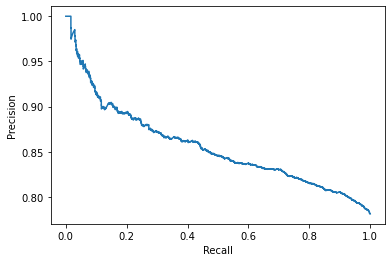

In [44]:
# Generate the precision-recall curve
precision, recall, threshold_vals = precision_recall_curve(y_test, y_test_pred_prob)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')

Notice that the precision still remains high (above 0.7 uniformly, and mostly above 0.8) on the y-axis even as the recall shifts from 0 to 1. Therefore, out of all of the questions classified as positive questions, even as we increase the recall (which is the proportion of truly positive questions that are classified as positive) to 1, the proportion of the positively-classified questions that are truly positive remains high. 